In [1]:

import urllib.request
import os
import tarfile
import urllib

#DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2"
DOWNLOAD_ROOT = "https://github.com/kaiyungtan/Real-Estate-data-analysis/tree/master/data"

HOUSING_PATH = os.path.abspath("datasets/housing")
HOUSING_URL = DOWNLOAD_ROOT + "clean/belgium_real_estate.csv"

In [2]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")   
    if not os.path.exists(csv_path):
        print("CSV file does not exist at path:", csv_path)
        return None
    
    return pd.read_csv(csv_path)

housing_data = load_housing_data()

if housing_data is not None:
    housing_data.head()
else:
    print("No data loaded.")
    

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


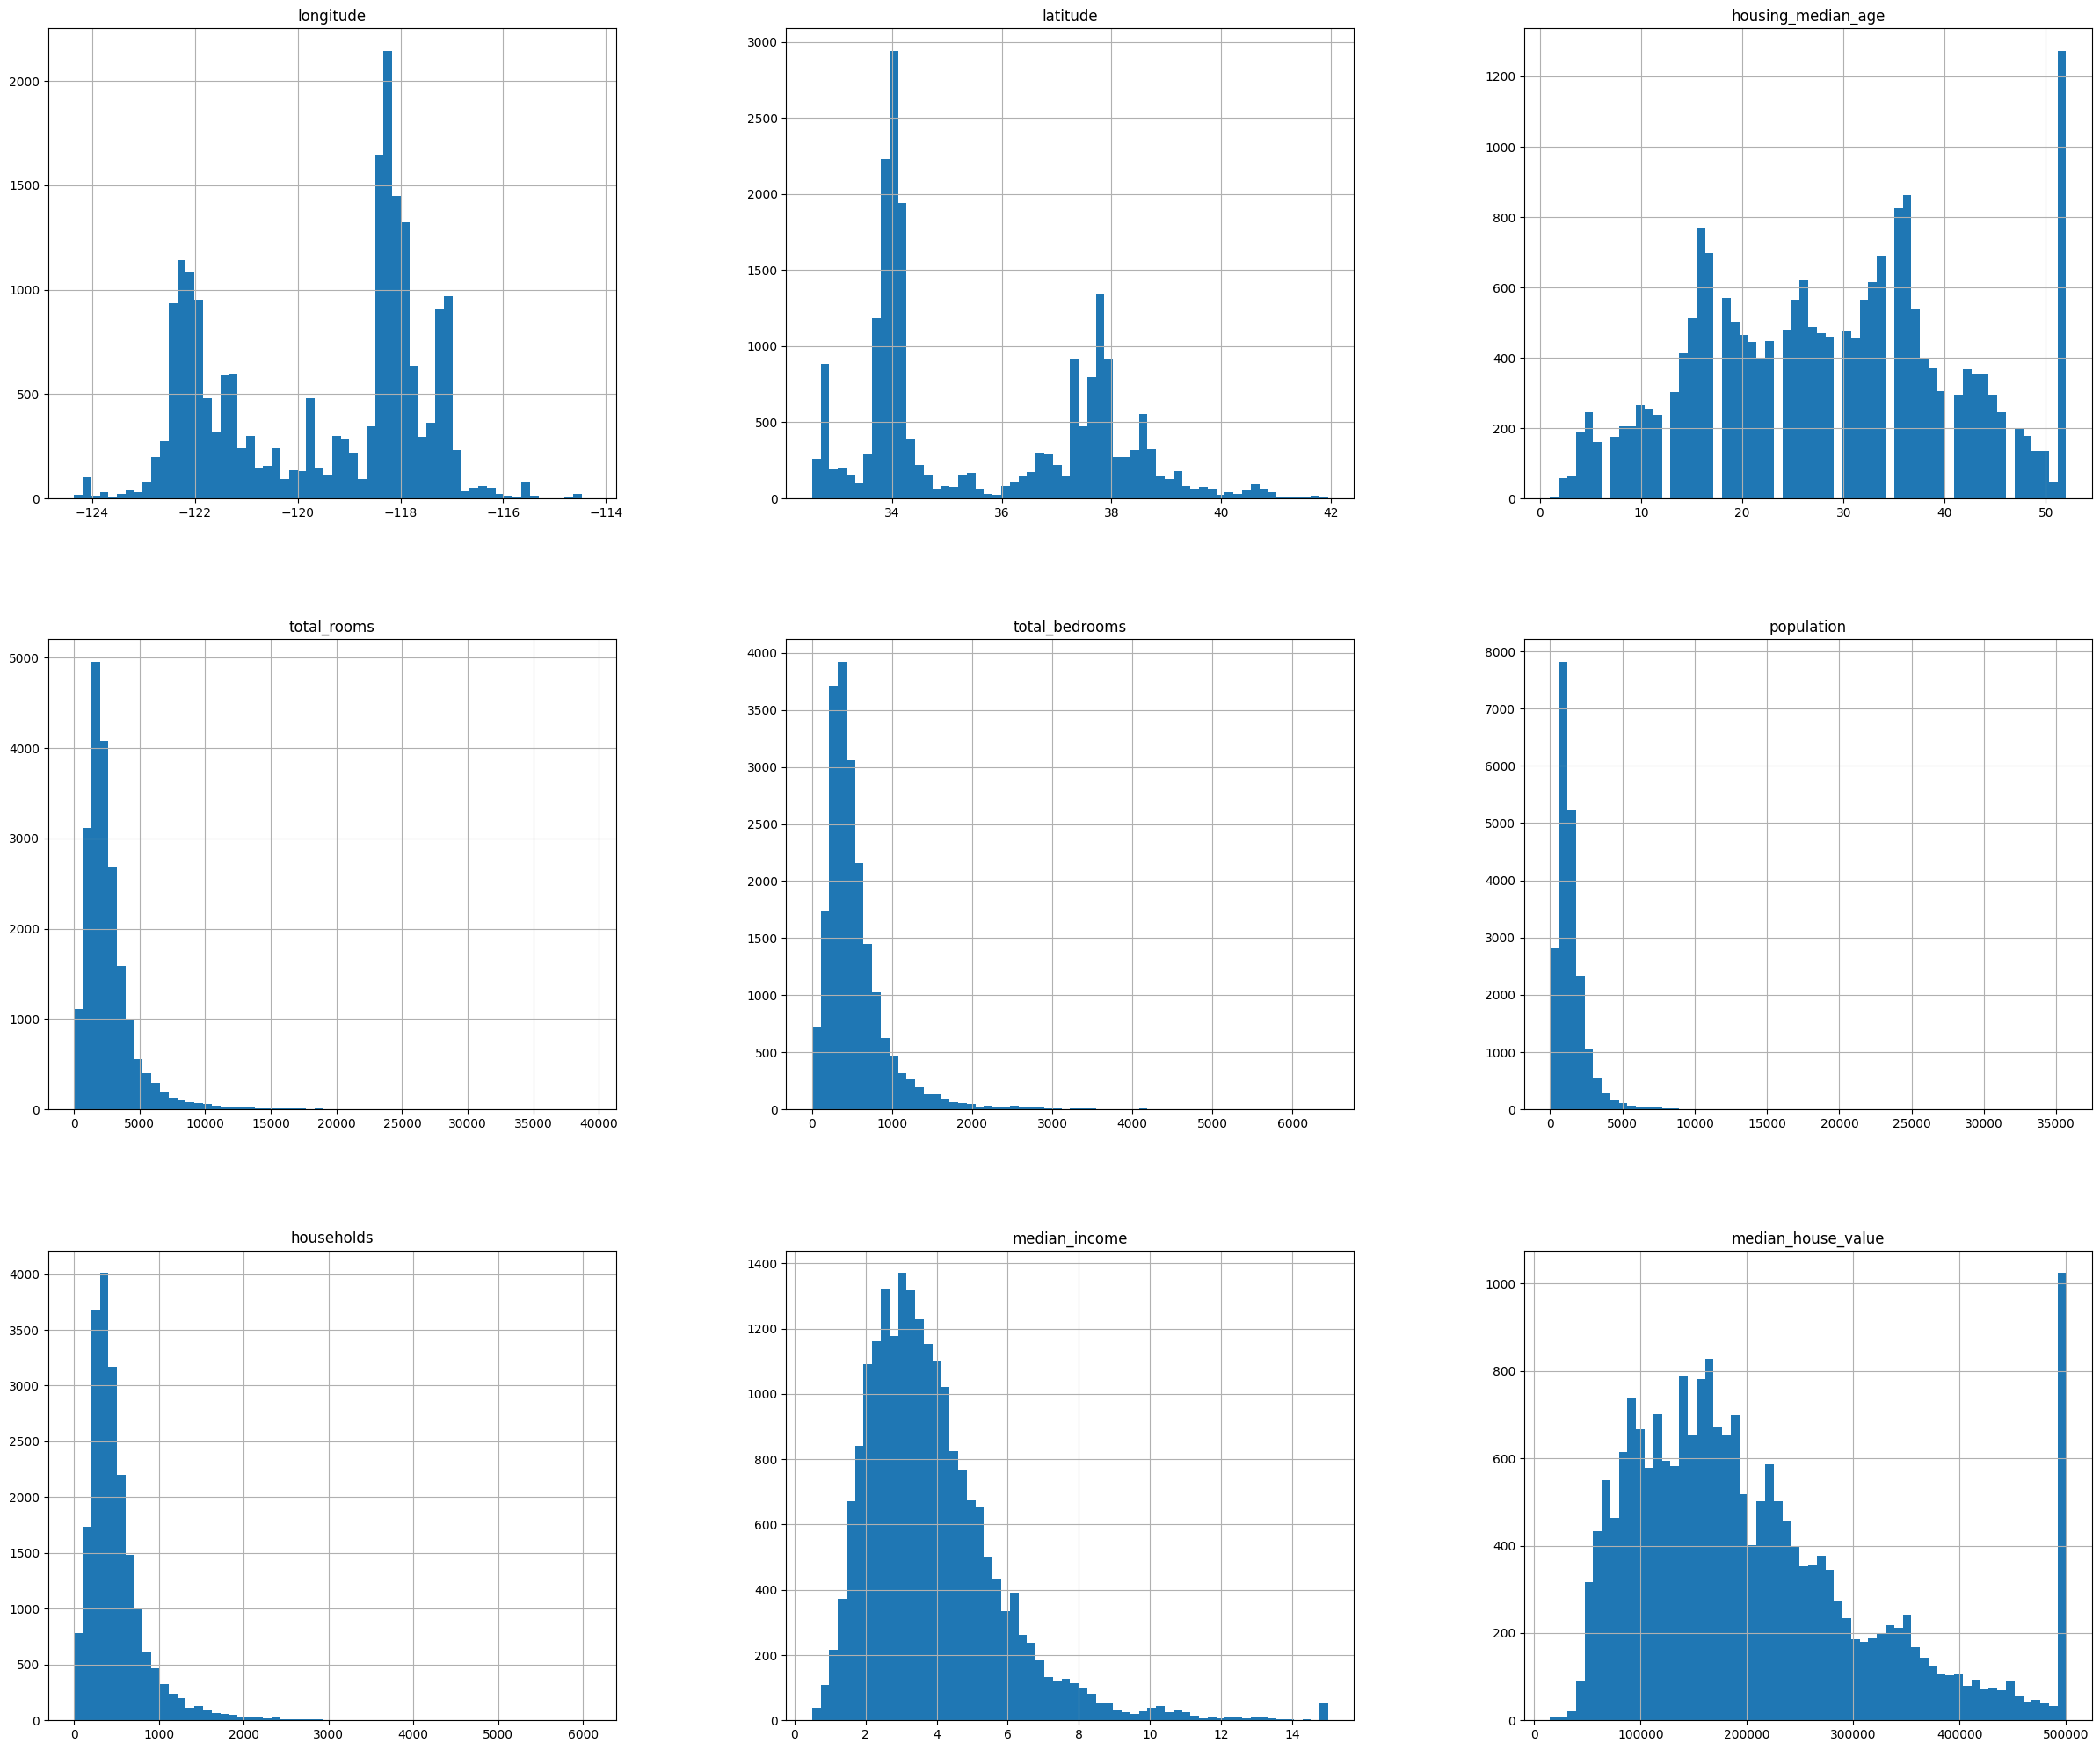

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=60, figsize=(30, 25))

plt.show()

In [6]:
import numpy as np 
def split_training_data(data, test_ratio):
    shuffled_incices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_incices[:test_set_size]
    train_indices = shuffled_incices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]




In [7]:
train_set, test_set = split_training_data(housing, 0.2)
len(train_set)

16512

In [8]:
len(test_set)

4128

In [9]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff<test_ratio*2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [10]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<Axes: >

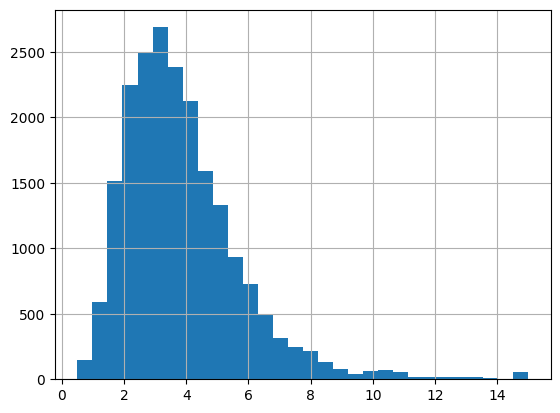

In [11]:
housing.median_income.hist(bins=30)

In [12]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")


In [13]:
housing_with_id["id"] = housing["longitude"]*1000+housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

<Axes: >

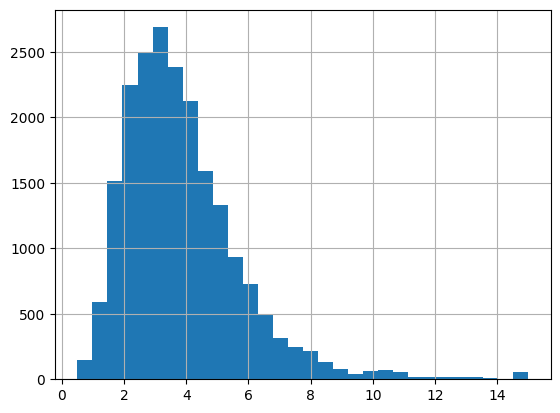

In [14]:
housing.median_income.hist(bins=30)

In [15]:
housing["income_cat"]= pd.cut(housing["median_income"], 
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])

<Axes: >

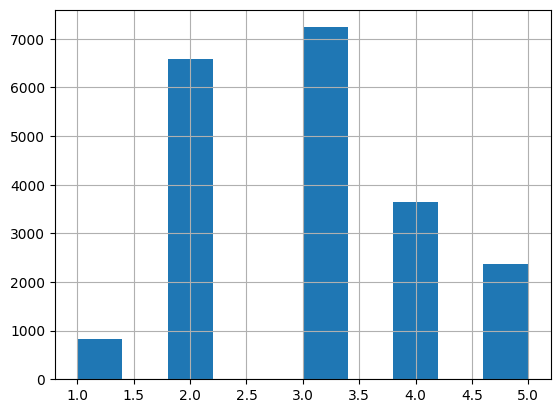

In [16]:
housing["income_cat"].hist()

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [18]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)


income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [19]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [20]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

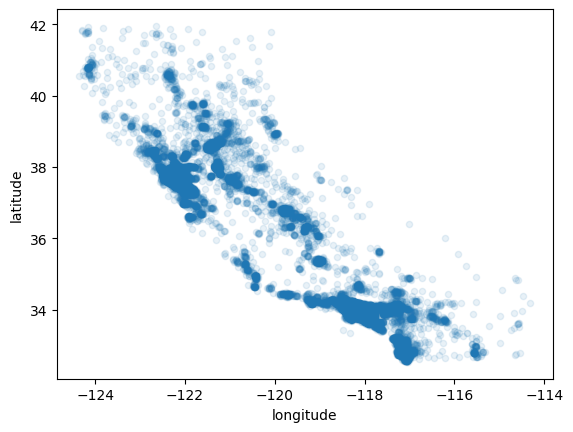

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

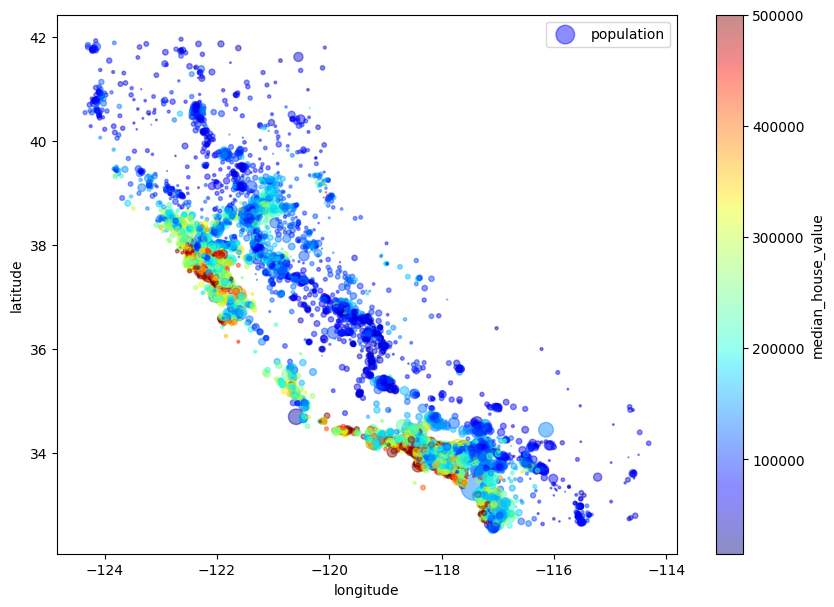

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.45,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             )
plt.legend()

In [23]:
import pandas as pd
housing_path = 'datasets/housing/housing.csv'
housing_pure_num = pd.read_csv(housing_path, usecols=['longitude','latitude','housing_median_age',
                                                 'total_rooms','total_bedrooms','population',
                                                 'households','median_income','median_house_value'])
cor_matrix = housing_pure_num.corr()

In [24]:
cor_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='longitude', ylabel='longitude'>,
        <Axes: xlabel='latitude', ylabel='longitude'>,
        <Axes: xlabel='housing_median_age', ylabel='longitude'>,
        <Axes: xlabel='median_income', ylabel='longitude'>,
        <Axes: xlabel='total_rooms', ylabel='longitude'>,
        <Axes: xlabel='median_house_value', ylabel='longitude'>],
       [<Axes: xlabel='longitude', ylabel='latitude'>,
        <Axes: xlabel='latitude', ylabel='latitude'>,
        <Axes: xlabel='housing_median_age', ylabel='latitude'>,
        <Axes: xlabel='median_income', ylabel='latitude'>,
        <Axes: xlabel='total_rooms', ylabel='latitude'>,
        <Axes: xlabel='median_house_value', ylabel='latitude'>],
       [<Axes: xlabel='longitude', ylabel='housing_median_age'>,
        <Axes: xlabel='latitude', ylabel='housing_median_age'>,
        <Axes: xlabel='housing_median_age', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes:

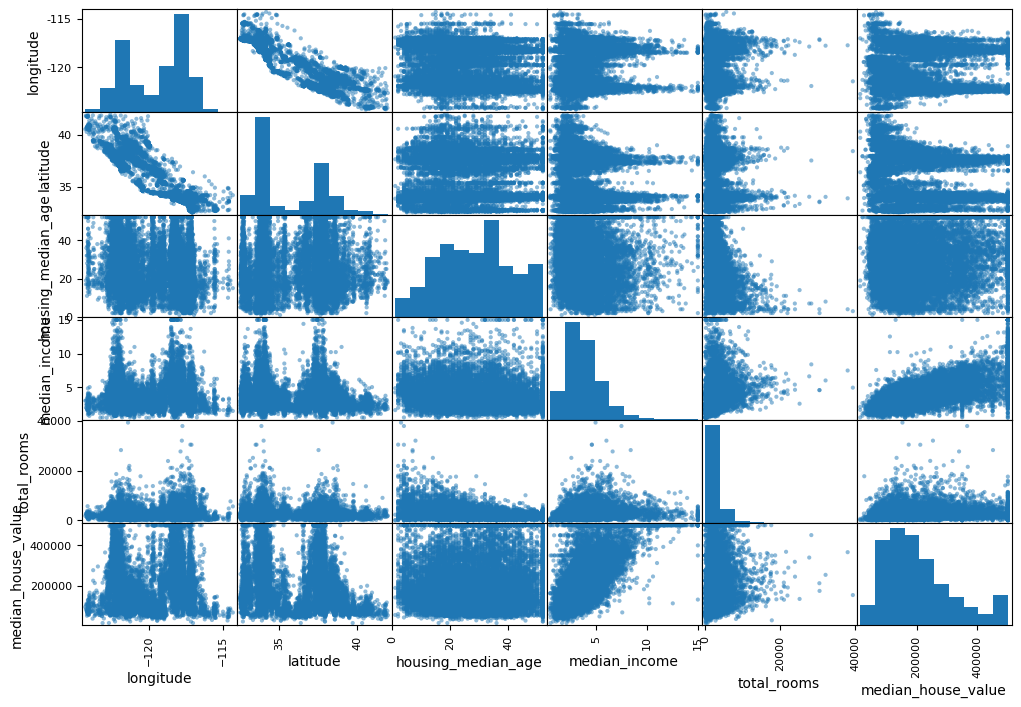

In [25]:
from pandas.plotting import scatter_matrix
attributes = ['longitude','latitude','housing_median_age', 'median_income',
              'total_rooms', 'median_house_value']
scatter_matrix(housing[attributes], figsize=(12, 8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

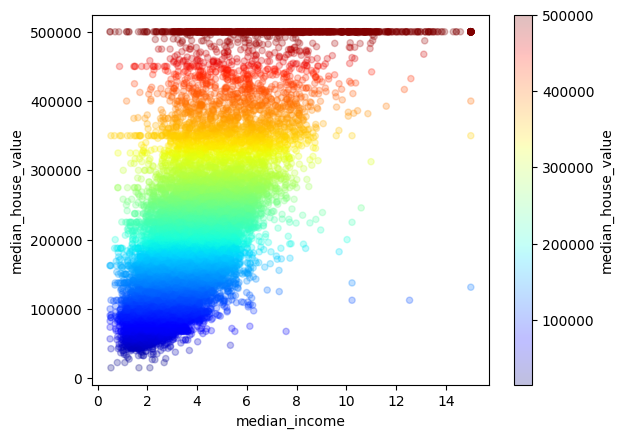

In [26]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', c = 'median_house_value',cmap=plt.get_cmap('jet'),
             alpha=0.25, colorbar=True)

In [27]:
housing["rooms_per_household"]= housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]= housing["population"]/housing["households"]

In [28]:
#We are going to have to remove INLAND column as that is not numerical data
df = pd.read_csv('datasets/housing/housing.csv')
column_to_remove = ['ocean_proximity']
housing = housing.drop(columns=column_to_remove)

correlation_matrix = housing.corr()
correlation_matrix["median_house_value"].sort_values(ascending=False)


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [29]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [30]:
housing.dropna(subset=["total_bedrooms"]) 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN


In [31]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [32]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [33]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [34]:
X = imputer.transform(housing_num)

In [35]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [36]:
from sklearn.preprocessing import OrdinalEncoder
ordenal_encoder = OrdinalEncoder()
housing_cat_encoded = ordenal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]


array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [37]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        
        rooms_per_household = X[:, rooms_ix]/X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)


In [40]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num) #Here there are only listed numerical values
cat_attribs = ["ocean_proximity"] #This is text attribute

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing)

In [41]:
#Now we will train our data with Machine Learning model "Linear Regression" first model we are trying
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Prediction: ", lin_reg.predict(some_data_prepared))
print("Labels: ", list(some_labels))


Prediction:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [42]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [43]:
from sklearn.tree import DecisionTreeRegressor # Second model we are trying

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [44]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)


In [45]:
def display_scores(scores):
    print(f"Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

display_scores(tree_rmse_scores)

Scores:  [72624.48978483 70246.76247211 68366.32128686 70953.63507438
 69229.83142558 75748.60014654 70839.58123605 74106.68069562
 68461.71628914 72869.33837535]
Mean:  71344.69567864726
Standard deviation:  2329.244628895476


In [46]:
from sklearn.ensemble import RandomForestRegressor #Third model we are trying
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)


housing_predictions_forest = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions_forest)
forest_rmse = np.sqrt(tree_mse)
forest_rmse


0.0

In [ ]:
forest_scores = cross_val_score(forest_reg, housing_prepared, 
                                housing_labels, 
                                scoring="neg_mean_squared_error", 
                                cv=10
                                )   
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse)